In [7]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.callback.fp16 import *

In [8]:
ds_folder = Path('../../Datasets')
path = Path(ds_folder/'oxford-iiit-pet')
Path.BASE_PATH = path
path.ls()

(#2) [Path('annotations'),Path('images')]

In [9]:
(path/"images").ls()

(#7393) [Path('images/Abyssinian_1.jpg'),Path('images/Abyssinian_10.jpg'),Path('images/Abyssinian_100.jpg'),Path('images/Abyssinian_100.mat'),Path('images/Abyssinian_101.jpg'),Path('images/Abyssinian_101.mat'),Path('images/Abyssinian_102.jpg'),Path('images/Abyssinian_102.mat'),Path('images/Abyssinian_103.jpg'),Path('images/Abyssinian_104.jpg')...]

In [12]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images", num_workers=0)

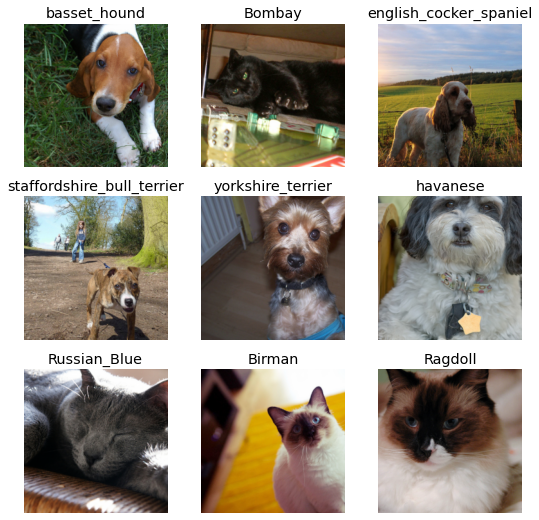

In [8]:
dls.show_batch()

In [14]:
learn = cnn_learner(dls, resnet50, metrics=accuracy).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,1.412694,0.323449,0.897835,01:07
1,0.602875,0.251154,0.922192,01:07
2,0.393746,0.284320,0.907984,01:08


epoch,train_loss,valid_loss,accuracy,time
0,0.263043,0.270468,0.913396,01:15
1,0.293504,0.356705,0.899865,01:15
2,0.225044,0.294069,0.916779,01:15
3,0.152761,0.250084,0.930311,01:15
4,0.085877,0.205988,0.937754,01:15
5,0.056486,0.212048,0.942490,01:15


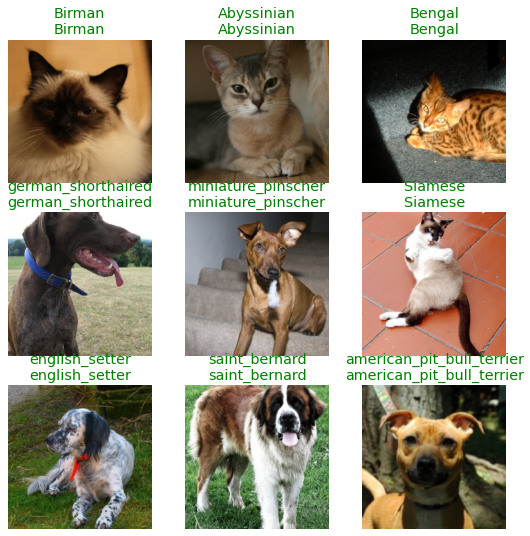

In [15]:
learn.show_results()

# My improvements

Batch Normalization, bigger image size, presizing

In [10]:
def get_dls(batch_size=32,image_size=224):
    db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=[*aug_transforms(size=image_size, min_scale=0.75, mult=2), 
                               Normalize.from_stats(*imagenet_stats)]
                 )
    return db.dataloaders(path/"images", bs=batch_size, num_workers=0)

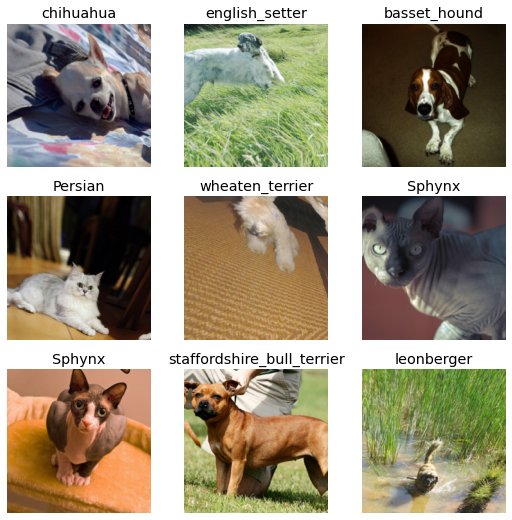

In [50]:
dls2 = get_dls(16)
dls2.show_batch()

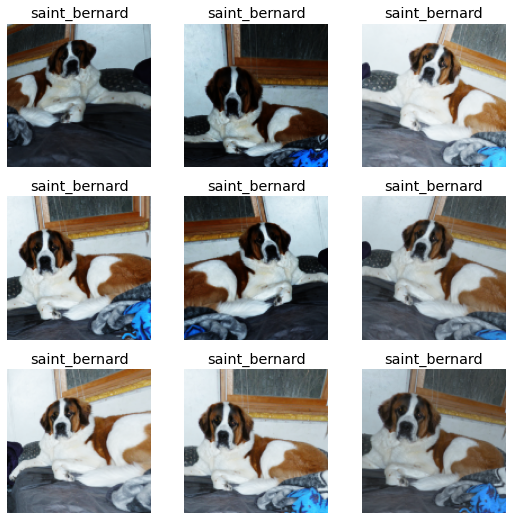

In [38]:
dls2.show_batch(unique=True)

In [51]:
# resnet18 acc = 94.18%, resnet152 = higher 0.15% (ew)
myLearn = cnn_learner(dls2, resnet50, metrics=accuracy)

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.001737800776027143)

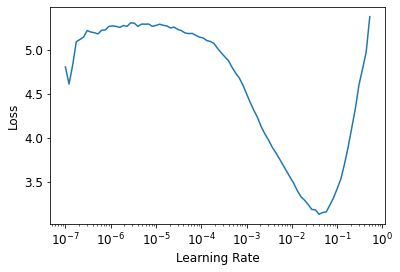

In [65]:
myLearn.lr_find()

In [52]:
# compare to default ch5 value = 0.942490. 
# 94.72%-94.25%=0.47%
myLearn.fine_tune(8, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,0.906255,0.353389,0.893775,01:43
1,0.748649,0.286906,0.910690,01:42
2,0.732404,0.334344,0.893099,01:42


epoch,train_loss,valid_loss,accuracy,time
0,0.558291,0.271423,0.920839,02:03
1,0.681153,0.376972,0.901894,02:01
2,0.625123,0.311171,0.911367,02:01
3,0.544974,0.319297,0.904601,02:02
4,0.416598,0.261274,0.921516,02:03
5,0.250251,0.219740,0.931664,02:03
6,0.175841,0.199523,0.941813,02:03
7,0.168610,0.193678,0.947226,02:04


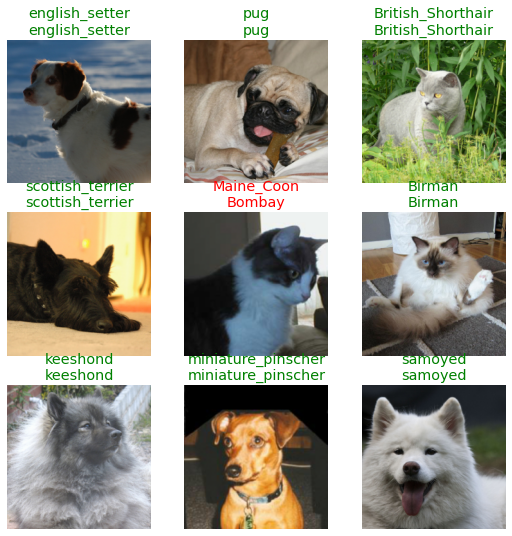

In [53]:
myLearn.show_results()

# TTA

- Use the fastai documentation to build a function that crops an image to a square in each of the four corners; then implement a TTA method that averages the predictions on a center crop and those four crops. Did it help? Is it better than the TTA method of fastai?

The answer to this question uses low level API that we haven't learned yet so... I'm just copying an answer I got from fastai forum.

[Answer Source](https://github.com/asiedubrempong/fastai-experiments/blob/master/tta.ipynb)

In [54]:
class UpperLeft(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img[..., :self.size, :self.size]

class UpperRight(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img[..., :self.size, w-self.size:]

class LowerLeft(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img[..., h-self.size:, :self.size]

class LowerRight(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img[..., h-self.size:, w-self.size:]

def tta_cc(learn, dl, size):
    tfms = [UpperLeft(size), UpperRight(size), LowerLeft(size), LowerRight(size)]
    tta_preds = []
    # get predictions for default approach on validation sets that uses the center crop
    preds, targs = learn.get_preds()
    tta_preds.append(preds[None])
    # get predictions using each of the four corner crops
    for tfm in tfms:
        dl = dl.new(after_batch=Pipeline([IntToFloatTensor, tfm]))
        tta_preds.append(learn.get_preds(dl=dl, inner=True)[0][None])
    
    tta_preds = torch.cat(tta_preds).mean(0)
    return tta_preds, targs

In [55]:
# my TTA
myPreds, myTargs = tta_cc(myLearn, myLearn.dls.valid, 224)
accuracy(myPreds, myTargs).item()

0.7151556015014648

In [56]:
# default fastai TTA
preds,targs = myLearn.tta()
accuracy(preds, targs).item()

0.9492557644844055

- fastai's TTA is much better than the custom TTA.
- fastai's TTA is about 0.2% more accurate than if we don't use TTA.

# Save/Load

In [70]:
export_file_name = '5_pet_breed.pkl'
myLearn.export(fname=export_file_name)

In [ ]:
myLearn = load_learner(export_file_name)